In [1]:
import Pkg; Pkg.activate("./")

  Activating project at `~/Documents/Research/MonitoringMetrology/BackAction.jl/notebooks`


# Monte Carlo Wavefunction Method

In [2]:
using Random, Statistics, Plots, LaTeXStrings, DifferentialEquations, LinearAlgebra, BackAction, Base.Threads

Precompiling packages...
  13195.4 ms  ✓ BackAction
  1 dependency successfully precompiled in 15 seconds. 277 already precompiled.


# Example 1: Radiative Damping

Here we consider the (base) jumps and hamiltonian:
$$ H = \frac{\Delta\omega}{2}\sigma_z $$
$$ L = \sqrt{\gamma}\sigma_- $$

with a $T$ parametrization and coherent fields

In [3]:
Tid = 1/sqrt(2) * [1 1im; 1 1im]
function rotation_matrix(theta)
    R = [cos(theta) -sin(theta); sin(theta) cos(theta)]
    return R
end
ntimes = 200
params = BackAction.rd_params;
t_eval = collect(LinRange(0.0, params.tf, ntimes));

In [4]:
function get_z_sample(theta)
    T = rotation_matrix(theta)*Tid#reshape([1.0 + 0.0im], 1,1)
    alphas = [3.3 + 0.0im; 3.3 + 0.0im]
    sys = System(BackAction.rd_H, [BackAction.rd_L], T, alphas)
    sim = get_sol_jumps(sys, params, t_eval)
    z_sample = Array{Float64}(undef, ntimes, params.ntraj)
    @threads for n in 1:params.ntraj
                 for t in 1:ntimes
                     psi = sim[n](t_eval[t])
                     z_sample[t, n] = real(dot(psi, BackAction.sigma_z, psi))/dot(psi, psi)
                 end
    end 
    return z_sample
end 

get_z_sample (generic function with 1 method)

In [71]:
z_sample1 = get_z_sample(1.5);
z_sample2 = get_z_sample(1.8);
z_sample3 = get_z_sample(0.8);

LoadError: InterruptException:

In [52]:
plot(t_eval, z_sample1[:, 1], label="Sample trajectory T1", xlabel=L"t", ylabel=L"\langle\sigma_z\rangle", title="Radiative Damping")
plot!(t_eval, z_sample2[:, 2], label="Sample trajectory T2")
plot!(t_eval, z_sample3[:, 3], label="Sample trajectory T3")
scatter!(t_eval, dropdims(mean(z_sample1, dims=2), dims=2), label="Average T1")
scatter!(t_eval, dropdims(mean(z_sample2, dims=2), dims=2), label="Average T2", markersize=2, markershape=:star)
scatter!(t_eval, dropdims(mean(z_sample3, dims=2), dims=2), label="Average T3", markersize=2, markershape=:diamond)
plot!(t_eval, t -> 2*exp(-BackAction.rd_gamma*t) - 1, label="Analytical", linewidth=3, line=:dash)

In [53]:
plot(t_eval, z_sample1[:, 1], label="Sample trajectory T1", xlabel=L"t", ylabel=L"\langle\sigma_z\rangle", title="Radiative Damping")
scatter!(t_eval, dropdims(var(z_sample1, dims=2), dims=2), label="Average T1")
scatter!(t_eval, dropdims(var(z_sample2, dims=2), dims=2), label="Average T2", markersize=2, markershape=:star)
scatter!(t_eval, dropdims(var(z_sample3, dims=2), dims=2), label="Average T3", markersize=2, markershape=:diamond)

# Example 2: Driven Qubit


In [3]:
function su2_matrix(theta, phi, psi)
    return [exp(1im*phi)*cos(theta) exp(1im*psi)*sin(theta); -exp(-1im*psi)*sin(theta) exp(-1im*phi)*cos(theta)]
end 

su2_matrix (generic function with 1 method)

In [4]:
# Parameters and time evaluation
ntimes = 75
params = SimulParameters([1.0+0im; 0.0], #initial condition
    25.0, #tf
    1, # seed
    1_000, # Number of trajectories
    # You can ignore the rest, they are only used for the Gillipsie method
    25_000, # Number of samples in the finegrid
    4.0, # Multiplier to use in the fine grid
    1e-3 # Tolerance for passing Dark state test
)
t_eval = collect(LinRange(0.0, params.tf, ntimes));
gamma = 1.0
delta = 0.5
omega = 0.5
nbar= 0.0

H = 0.5*delta*BackAction.sigma_z + 0.5*omega*BackAction.sigma_x
L1 = sqrt(gamma*(nbar+1))*BackAction.sigma_m
L2 = sqrt(gamma*(nbar))*BackAction.sigma_p
T1 = su2_matrix(2pi*rand(), 2*pi*rand(), 2*pi*rand())
T2 = su2_matrix(2pi*rand(), 2*pi*rand(), 2*pi*rand())
T3 = su2_matrix(2pi*rand(), 2*pi*rand(), 2*pi*rand())
alphas = [1.0 + 0.0im; 1.0 + 0.0im]

 

2-element Vector{ComplexF64}:
 1.0 + 0.0im
 1.0 + 0.0im

In [13]:
function generate_trajectory_ensemble(T)
    sys = System(H, [L1, L2], T, alphas)
    # Problem definition
    @time begin
    sim = get_sol_jumps(sys, params, t_eval);
    end
    return sim
end 

function get_r_sample(sim)
    # observable evaluation 
    r_sample = Array{Float64}(undef, 3, ntimes,params.ntraj)
    sigma = [BackAction.sigma_x, BackAction.sigma_y, BackAction.sigma_z]
    @threads for n in 1:params.ntraj
                 for t in 1:ntimes
                    psi = sim[n](t_eval[t])
                    for k in 1:3
                        r_sample[k, t, n] = real(dot(psi, sigma[k], psi))/dot(psi, psi)
                     end
                 end 
            end 
    return r_sample
end

get_r_sample (generic function with 1 method)

In [15]:
# Parameters definition and problem initialization
sim1 = generate_trajectory_ensemble(T1)
sim2 = generate_trajectory_ensemble(T2)
sim3 = generate_trajectory_ensemble(T3)
r_sample1 = get_r_sample(sim1);
r_sample2 = get_r_sample(sim2);
r_sample3 = get_r_sample(sim3);

  1.946352 seconds (44.55 M allocations: 3.822 GiB, 40.62% gc time)
  1.947542 seconds (39.77 M allocations: 3.415 GiB, 48.53% gc time)
  1.521945 seconds (37.27 M allocations: 3.201 GiB, 38.03% gc time)


In [7]:
# Analytical solution
function resonance_fluorescene!(du, u, p, t)
    #     -0.5*gamma*(2*nbar+1)*r[1] - delta*r[2]
    # delta*r[1] - 0.5*gamma*(2*nbar+1)*r[2] - omega*r[3];
    # omega*r[2] - gamma*(2*nbar+1)*r[3] - gamma]

    du[1] = - 0.5*gamma*(2*nbar+1)*u[1] - delta*u[2]  
    du[2] = + delta*u[1] - 0.5*gamma*(2*nbar+1)*u[2]- omega*u[3]  
    du[3] = omega*u[2] - gamma*(2*nbar+1)*u[3] - gamma
end
u0 = [0.0, 0.0, -1.0]
prob_analytical = ODEProblem(resonance_fluorescene!, u0, extrema(t_eval))
sol_analytical = solve(prob_analytical);

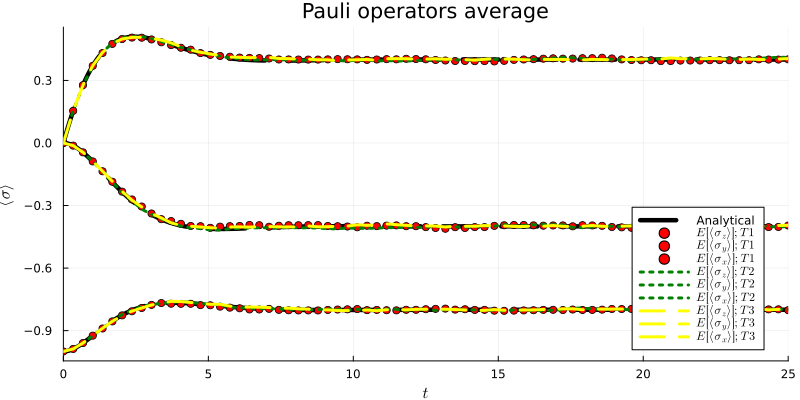

In [16]:
# Analytical
plot(sol_analytical, idxs=(0,3), label="Analytical", color="black", line=:dash, linewidth=4.5)
plot!(sol_analytical, idxs=(0,2), label=false, color="black",line=:dash, linewidth=4.5)
plot!(sol_analytical, idxs=(0,1), label=false, color="black",line=:dash, linewidth=4.5)
# T1
scatter!(t_eval, dropdims(mean(r_sample1[3, :, :], dims=2), dims=2), label=L"E[\langle\sigma_z\rangle]; T1", linewidth=3.0, color="red",
    title="Pauli operators average", size=(800, 400))
scatter!(t_eval, dropdims(mean(r_sample1[2, :, :], dims=2), dims=2), label=L"E[\langle\sigma_y\rangle]; T1", linewidth=3, color="red",
        )
scatter!(t_eval, dropdims(mean(r_sample1[1, :, :], dims=2), dims=2), label=L"E[\langle\sigma_x\rangle]; T1", linewidth=3, color="red",
        )
# T2
plot!(t_eval, dropdims(mean(r_sample2[3, :, :], dims=2), dims=2), label=L"E[\langle\sigma_z\rangle]; T2", linewidth=3, color="green",
    line=:dot)
plot!(t_eval, dropdims(mean(r_sample2[2, :, :], dims=2), dims=2), label=L"E[\langle\sigma_y\rangle]; T2", linewidth=3, color="green",
    line=:dot)
plot!(t_eval, dropdims(mean(r_sample2[1, :, :], dims=2), dims=2), label=L"E[\langle\sigma_x\rangle]; T2", linewidth=3, color="green",
    line=:dot)
#T3
plot!(t_eval, dropdims(mean(r_sample3[3, :, :], dims=2), dims=2), label=L"E[\langle\sigma_z\rangle]; T3", linewidth=3, color="yellow",
     line=:dash)
plot!(t_eval, dropdims(mean(r_sample3[2, :, :], dims=2), dims=2), label=L"E[\langle\sigma_y\rangle]; T3", linewidth=3, color="yellow",
    line=:dash)
plot!(t_eval, dropdims(mean(r_sample3[1, :, :], dims=2), dims=2), label=L"E[\langle\sigma_x\rangle]; T3", linewidth=3, color="yellow",
    line=:dash, xlabel=L"t", ylabel=L"\langle\sigma\rangle")

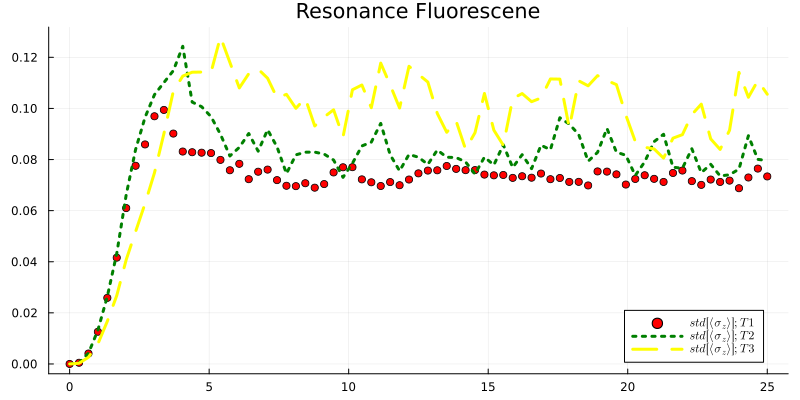

In [9]:
# T1
scatter(t_eval, dropdims(std(r_sample1[3, :, :], dims=2), dims=2), label=L"std[\langle\sigma_z\rangle]; T1", linewidth=3.0, color="red",
    title="Resonance Fluorescene", size=(800, 400))
#scatter!(t_eval, dropdims(std(r_sample1[2, :, :], dims=2), dims=2), label=L"std[\langle\sigma_y\rangle]; T1", linewidth=3, color="red",
#        )
#scatter(t_eval, dropdims(var(r_sample1[1, :, :], dims=2), dims=2), label=L"Var[\langle\sigma_x\rangle]; T1", linewidth=3, color="red",
#        title="Variance ")
# T2
plot!(t_eval, dropdims(std(r_sample2[3, :, :], dims=2), dims=2), label=L"std[\langle\sigma_z\rangle]; T2", linewidth=3, color="green",
    title="Resonance Fluorescene", size=(800, 400), line=:dot)
#plot!(t_eval, dropdims(std(r_sample2[2, :, :], dims=2), dims=2), label=L"std[\langle\sigma_y\rangle]; T2", linewidth=3, color="green",
#    line=:dot)
#plot!(t_eval, dropdims(var(r_sample2[1, :, :], dims=2), dims=2), label=L"Var[\langle\sigma_x\rangle]; T2", linewidth=3, color="green",
#    line=:dot)
#T3
plot!(t_eval, dropdims(std(r_sample3[3, :, :], dims=2), dims=2), label=L"std[\langle\sigma_z\rangle]; T3", linewidth=3, color="yellow",
    title="Resonance Fluorescene", size=(800, 400), line=:dash)
#plot!(t_eval, dropdims(std(r_sample3[2, :, :], dims=2), dims=2), label=L"std[\langle\sigma_y\rangle]; T3", linewidth=3, color="yellow",
#    line=:dash)
#plot!(t_eval, dropdims(var(r_sample3[1, :, :], dims=2), dims=2), label=L"Var[\langle\sigma_x\rangle]; T3", linewidth=3, color="yellow",
#    line=:dash, xlabel=L"t", ylabel=L"Var\langle\sigma\rangle")

# Testing the trajectory saving

In [33]:
"From the problem, obtain the trajectory"
function extract_trajectory(sol)
    times = sol.prob.kwargs[:callback].affect!.jump_times
    channels = sol.prob.kwargs[:callback].affect!.jump_channels
    njumps = length(times)
    traj = Vector{DetectionClick}(undef, njumps)
    @inbounds for k in 1:njumps   
       traj[k] = DetectionClick(times[k], channels[k]) 
    end  
    return traj
end

extract_trajectory

In [34]:
extract_trajectory(sim1[1])

50-element Vector{DetectionClick}:
 DetectionClick(0.691642964460224, 1)
 DetectionClick(1.2134406498670256, 1)
 DetectionClick(1.5218320864991493, 1)
 DetectionClick(1.5424087463596208, 2)
 DetectionClick(2.13216588039076, 2)
 DetectionClick(2.3869407715898685, 2)
 DetectionClick(2.761781065688086, 2)
 DetectionClick(3.31735573933668, 1)
 DetectionClick(3.9052799327915415, 1)
 DetectionClick(4.441020155481938, 2)
 DetectionClick(5.5825006960080215, 2)
 DetectionClick(5.643343213482531, 1)
 DetectionClick(5.771118211595198, 2)
 ⋮
 DetectionClick(19.91473870689424, 2)
 DetectionClick(20.20974371345212, 2)
 DetectionClick(20.434708197819717, 2)
 DetectionClick(20.669824417495686, 2)
 DetectionClick(20.69142469874419, 2)
 DetectionClick(21.201953156651616, 2)
 DetectionClick(21.552219558297, 2)
 DetectionClick(22.20833585603576, 1)
 DetectionClick(22.70792354348213, 1)
 DetectionClick(23.5348123044211, 1)
 DetectionClick(24.685975753388067, 2)
 DetectionClick(24.81738211452803, 1)

In [19]:
Vector{DetectionClick}(undef, 10)

10-element Vector{DetectionClick}:
 DetectionClick(6.90193870705857e-310, 139696794648960)
 DetectionClick(6.9019459088432e-310, 139696794649760)
 DetectionClick(6.90194590884005e-310, 139696723098560)
 DetectionClick(6.9019459088369e-310, 139696794648960)
 DetectionClick(6.90194590883373e-310, 139696723098560)
 DetectionClick(6.9018851056877e-310, 139696794648960)
 DetectionClick(6.90188528109446e-310, 139696723098560)
 DetectionClick(6.90193870701904e-310, 139696794648960)
 DetectionClick(6.90193870701904e-310, 139696794648960)
 DetectionClick(6.9019373270012e-310, 139696794658352)